In [9]:
import pyarrow.parquet as pq
from glob import glob
import os
country_code = 'US'
path_to_data = '/scratch/spf248/twitter/data'
tweets=pq.ParquetDataset(glob(os.path.join(path_to_data,
                                           'classification',
                                           country_code,'labeling',
                                           '*.parquet'))).read().to_pandas()
import pandas as pd
labels = pd.read_csv('/scratch/spf248/twitter/data/classification/US/labeled/labels.csv')

In [20]:
tweets['tweet_id'] = pd.to_numeric(tweets['tweet_id'], downcast='integer')
# training_data = tweets.join(labels, lsuffix='tweet_id', rsuffix='tweet_id')
training_data = pd.merge(tweets, labels, how='inner', on='tweet_id')
training_data = training_data[['1', '2', '3', '4', '5']]
training_data.columns = ["is_unemployed", "lost_job_1mo", "job_search","is_hired_1mo","job_offer"]
# label_cols = ["is_unemployed", "lost_job_1mo", "job_search","is_hired_1mo","job_offer"]
print(training_data.dtypes)
# training_data[['1', '2', '3', '4', '5']] = training_data[['1', '2', '3', '4', '5']].replace('unsure', 'no')
print(pd.unique(training_data['is_unemployed']))
training_data['dummy'] = 1
training_data.head()


is_unemployed    object
lost_job_1mo     object
job_search       object
is_hired_1mo     object
job_offer        object
dtype: object
['yes' 'no' 'unsure']


,is_unemployed,lost_job_1mo,job_search,is_hired_1mo,job_offer,dummy
0,yes,yes,no,no,no,1
1,yes,no,no,no,no,1
2,yes,no,no,no,no,1
3,no,no,no,no,no,1
4,no,yes,no,yes,no,1


In [62]:
count_df = pd.DataFrame()
for column in training_data.columns:
    count = pd.crosstab(training_data['dummy'], training_data[column]).rename_axis(None, axis=1)   
    count['label'] = column
    count_df = pd.concat([count_df, count])
    
count_df = count_df[['no', 'yes', 'unsure', 'label']]
count_df = count_df[:-1]
# print(count_df)

count_df = pd.melt(count_df, id_vars=['label'], value_vars=['no', 'yes', 'unsure'])
count_df['value'] = count_df['value'].astype(int)
count_df

,label,variable,value
0,is_unemployed,no,4221
1,lost_job_1mo,no,4607
2,job_search,no,4496
3,is_hired_1mo,no,4632
4,job_offer,no,4056
5,is_unemployed,yes,771
6,lost_job_1mo,yes,393
7,job_search,yes,523
8,is_hired_1mo,yes,376
9,job_offer,yes,957


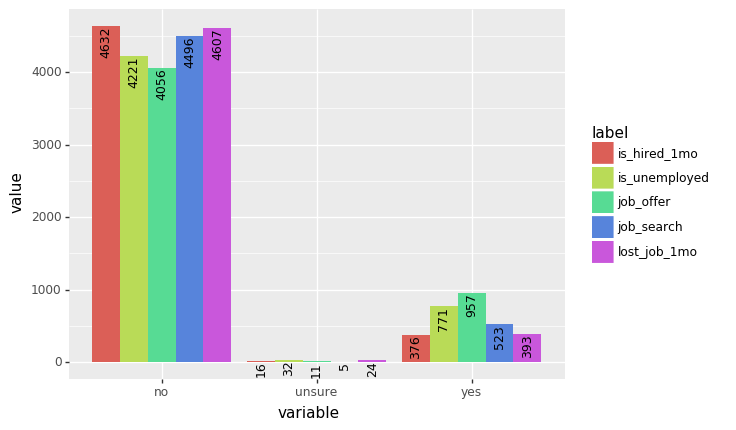

<ggplot: (2973916565353)>

In [73]:
from plotnine import *

ggplot(count_df, aes(x='variable', y='value', fill = 'label')) + \
    geom_bar(stat="identity", position=position_dodge()) + \
    geom_text(aes(label='value'), position=position_dodge(width=0.9), angle=90, vjust='top', size=9)

# ggplot(training_data) + geom_bar(aes(x = reorder('is_unemployed', order)))



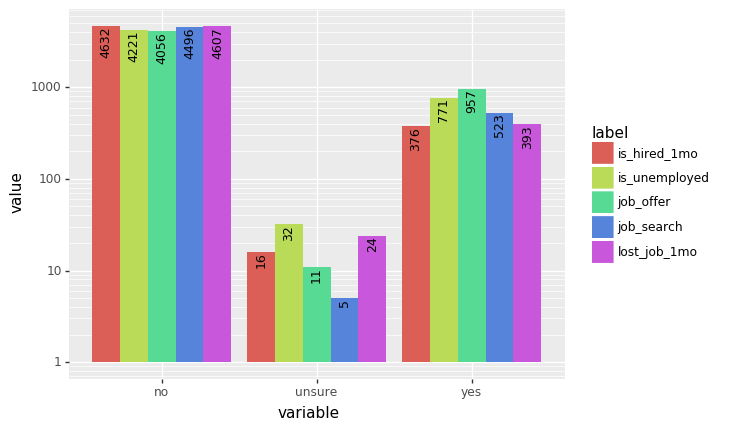

<ggplot: (2973892552997)>

In [74]:
from plotnine import *

ggplot(count_df, aes(x='variable', y='value', fill = 'label')) + \
    geom_bar(stat="identity", position=position_dodge()) + \
    geom_text(aes(label='value'), position=position_dodge(width=0.9), angle=90, vjust='top', size=9) +\
scale_y_log10()

# ggplot(training_data) + geom_bar(aes(x = reorder('is_unemployed', order)))



In [33]:
import matplotlib.pyplot as plt

order = ['no', 'unsure', 'yes']

for column in ["is_unemployed", "lost_job_1mo", "job_search","is_hired_1mo","job_offer"]:

    ggplot(training_data) + geom_bar(aes(x=column))

#     break

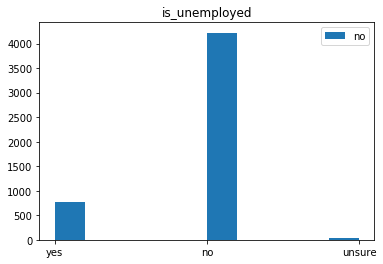

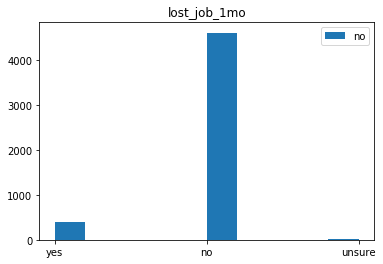

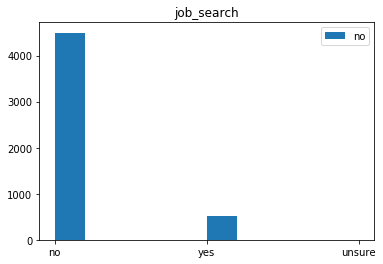

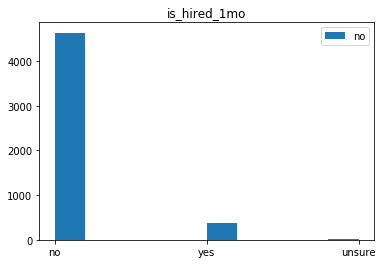

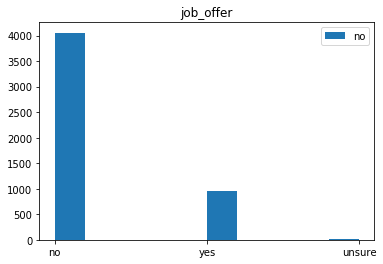

In [21]:
import matplotlib.pyplot as plt

order = ['no', 'unsure', 'yes']

for column in ["is_unemployed", "lost_job_1mo", "job_search","is_hired_1mo","job_offer"]:
    fig = plt.figure()
    ax = plt.subplot(111)
    
#     plt.hist(training_data[column],density = True)
    plt.hist(training_data[column], label = order)
    plt.savefig('../mturk_mar6/data/summary_bar_{}.png'.format(column))

    plt.title(column)
    ax.legend()

In [12]:
train, val = training_data[:int(.80*training_data.shape[0])], training_data[-int(.20*training_data.shape[0]):]
train.to_csv('/scratch/da2734/twitter/mturk_mar6/data/train.csv',index=False)
val.to_csv('/scratch/da2734/twitter/mturk_mar6/data/val.csv',index=False)